In [22]:
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

import cv2

import glob

import tensorflow
from tensorflow.keras.models import load_model

In [29]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
image_size = 224

In [9]:
mobile_net = load_model('mobile_net_v0_0.76.h5', compile=False)

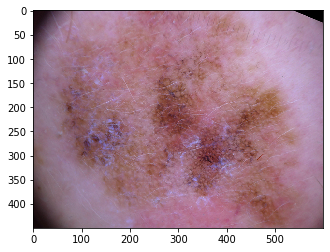

In [37]:
img = cv2.imread('../data_processed/validation/mel/ISIC_0024400.jpg')
plt.imshow(img[:,:,[2, 1, 0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


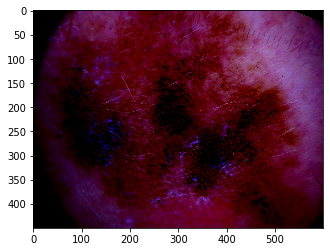

In [38]:
img = tensorflow.keras.applications.mobilenet.preprocess_input(img)
plt.imshow(img[:,:,[2, 1, 0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


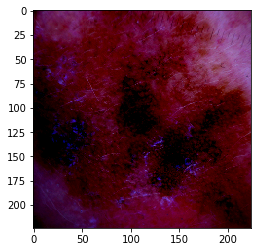

In [39]:
img = cv2.resize(img[:, 75:525, :], (image_size, image_size))
plt.imshow(img[:,:,[2, 1, 0]])

In [36]:
probs = mobile_net.predict(np.expand_dims(img, axis=0))
probs
np.argmax(probs)

array([[6.3098832e-06, 1.0242274e-03, 3.5649741e-01, 6.3918233e-02,
        1.3581082e-01, 4.4249815e-01, 2.4484645e-04]], dtype=float32)

5

In [12]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, mobile_net.predict, top_labels=5, hide_color=0, num_samples=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


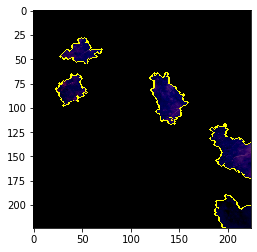

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


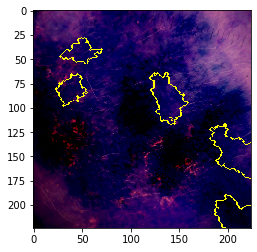

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


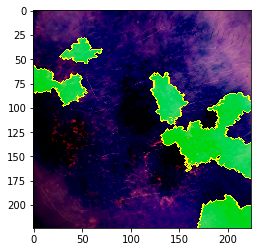

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


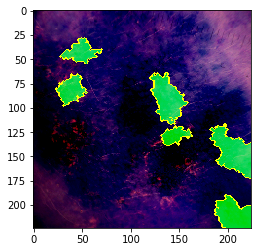

In [17]:
# min_weight=0.0015
# min_weight=0.002
# min_weight=0.001
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, 
                                            hide_rest=False,
                                            min_weight=0.002)
plt.imshow(mark_boundaries(temp, mask))